In [157]:
import pandas as pd
import numpy as np
import seaborn as sns

In [158]:
df = pd.read_csv("db/global-superstore-orders.csv")

In [159]:
df_monetary = df.groupby('Customer ID')['Sales'].sum()
df_monetary = df_monetary.reset_index()
df_monetary.head()

,Customer ID,Sales
0,AA-10315,13747.41300
1,AA-10375,5884.19500
2,AA-10480,17695.58978
3,AA-10645,15343.89070
4,AA-315,2243.25600


In [160]:
df_frequency = df.groupby('Customer ID')['Order ID'].count()
df_frequency = df_frequency.reset_index()
df_frequency.columns = ['Customer ID', 'Frequency']
df_frequency.head()

,Customer ID,Frequency
0,AA-10315,42
1,AA-10375,42
2,AA-10480,38
3,AA-10645,73
4,AA-315,8


In [161]:
last_order_date = pd.to_datetime(df['Order Date'].max())

df_recency = df.groupby('Customer ID')['Order Date'].max()
df_recency = df_recency.reset_index()
#df_recency.columns = ['Customer ID', 'Recency']
df_recency['Recency'] = (last_order_date - pd.to_datetime(df_recency['Order Date'])).dt.days
df_recency = df_recency.drop('Order Date', axis=1)
df_recency.head()


,Customer ID,Recency
0,AA-10315,355
1,AA-10375,1
2,AA-10480,733
3,AA-10645,367
4,AA-315,355


In [162]:
# Merge all datasets
df_cl = df_monetary.merge(df_frequency, on='Customer ID')
df_cl = df_cl.merge(df_recency, on='Customer ID')
df_cl.head()

,Customer ID,Sales,Frequency,Recency
0,AA-10315,13747.41300,42,355
1,AA-10375,5884.19500,42,1
2,AA-10480,17695.58978,38,733
3,AA-10645,15343.89070,73,367
4,AA-315,2243.25600,8,355


<AxesSubplot: ylabel='Sales'>

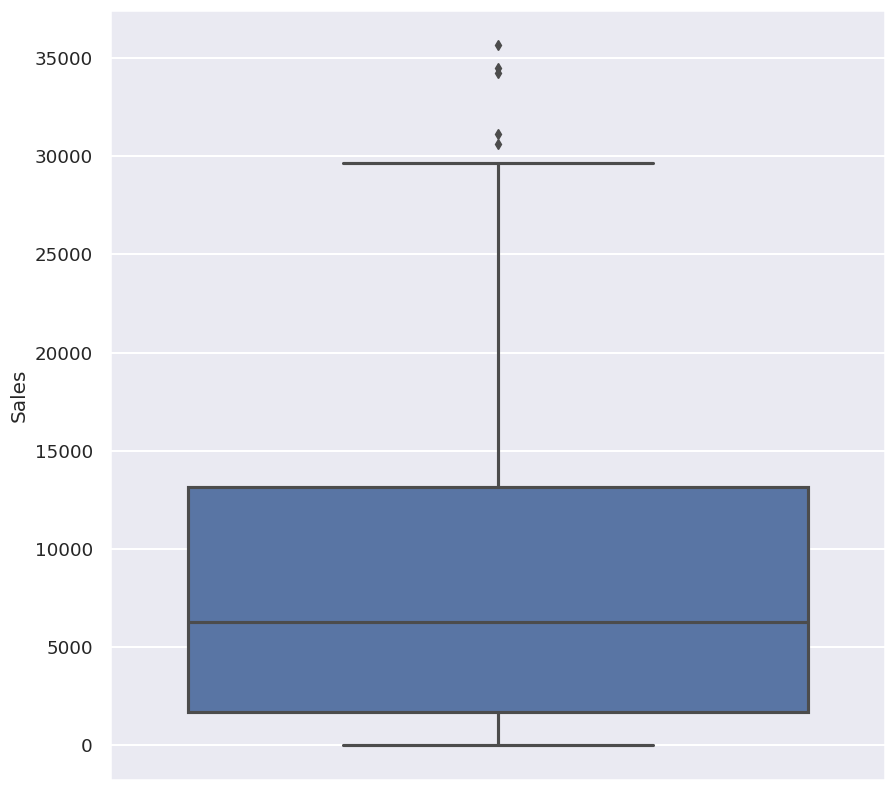

In [163]:
# Try to visualize with a boxplot these 3 parameters: are there outliers?
sns.boxplot(df_cl, y='Sales')

<AxesSubplot: ylabel='Frequency'>

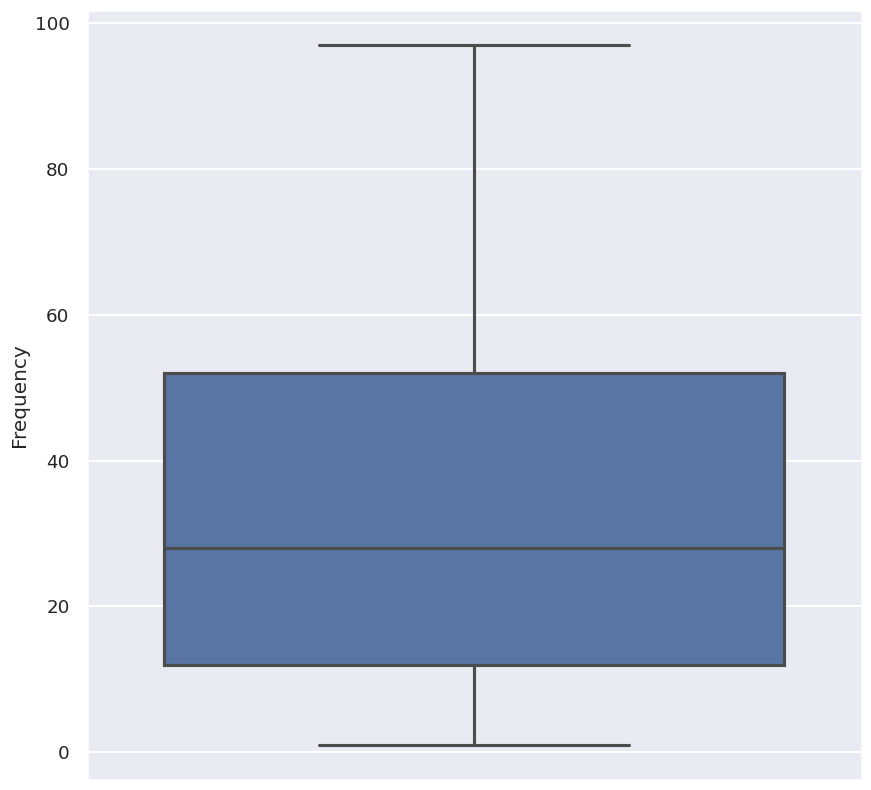

In [164]:
sns.boxplot(df_cl, y='Frequency')

<AxesSubplot: ylabel='Recency'>

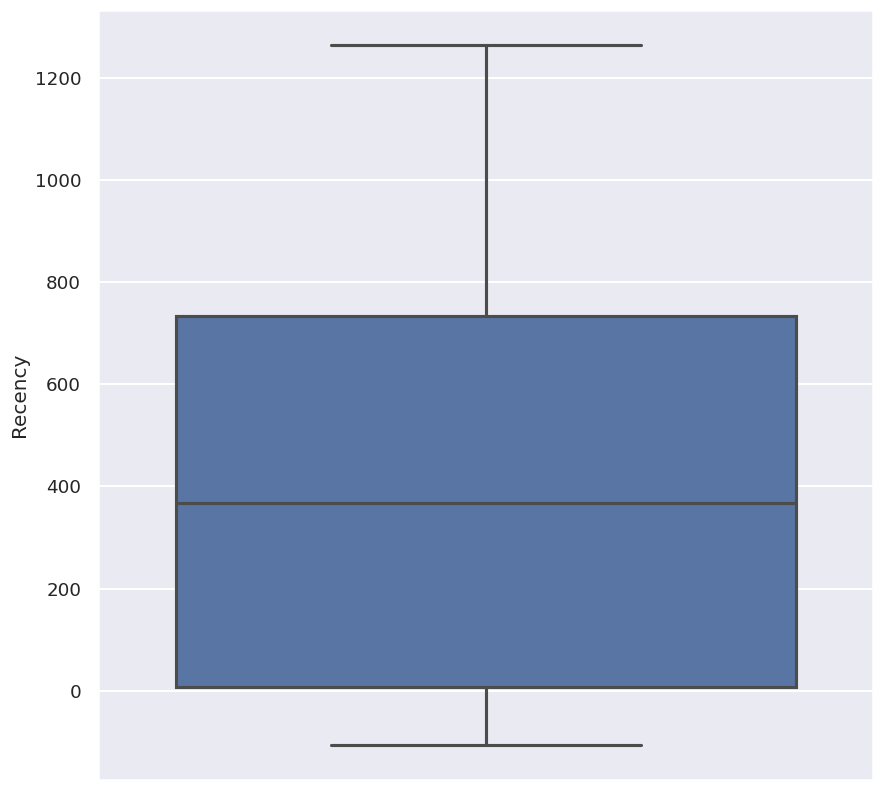

In [165]:
sns.boxplot(df_cl, y='Recency')

In [166]:
def remove_outliers_iqr(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

In [167]:
df_cl = remove_outliers_iqr(df_cl, 'Sales')
df_cl = remove_outliers_iqr(df_cl, 'Frequency')
df_cl = remove_outliers_iqr(df_cl, 'Recency')

<AxesSubplot: ylabel='Sales'>

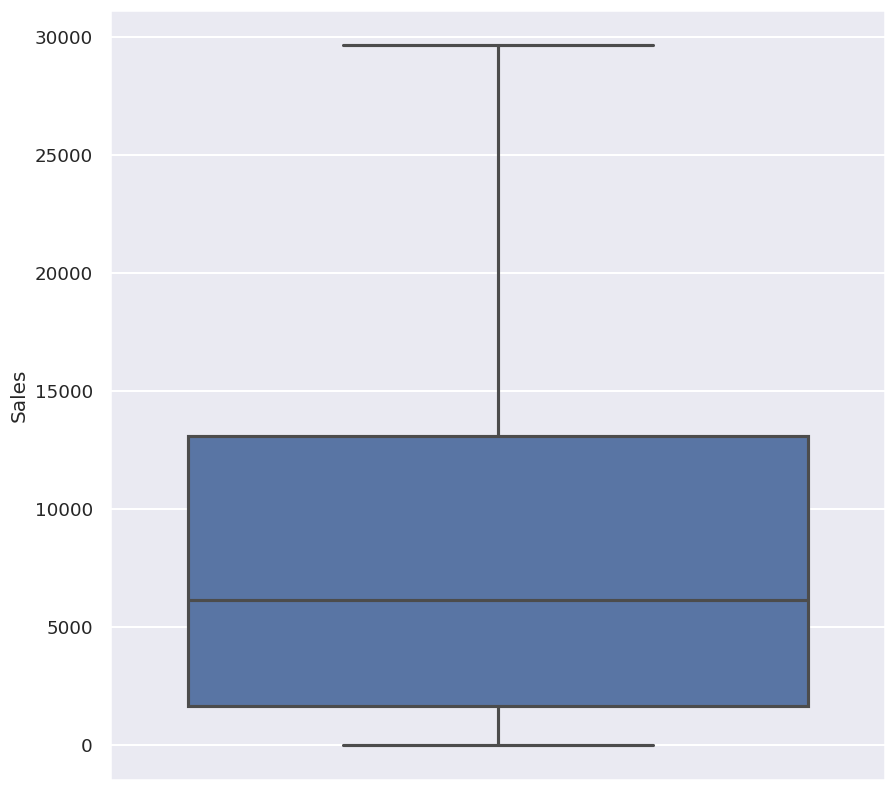

In [168]:
sns.boxplot(df_cl, y='Sales')

<AxesSubplot: ylabel='Frequency'>

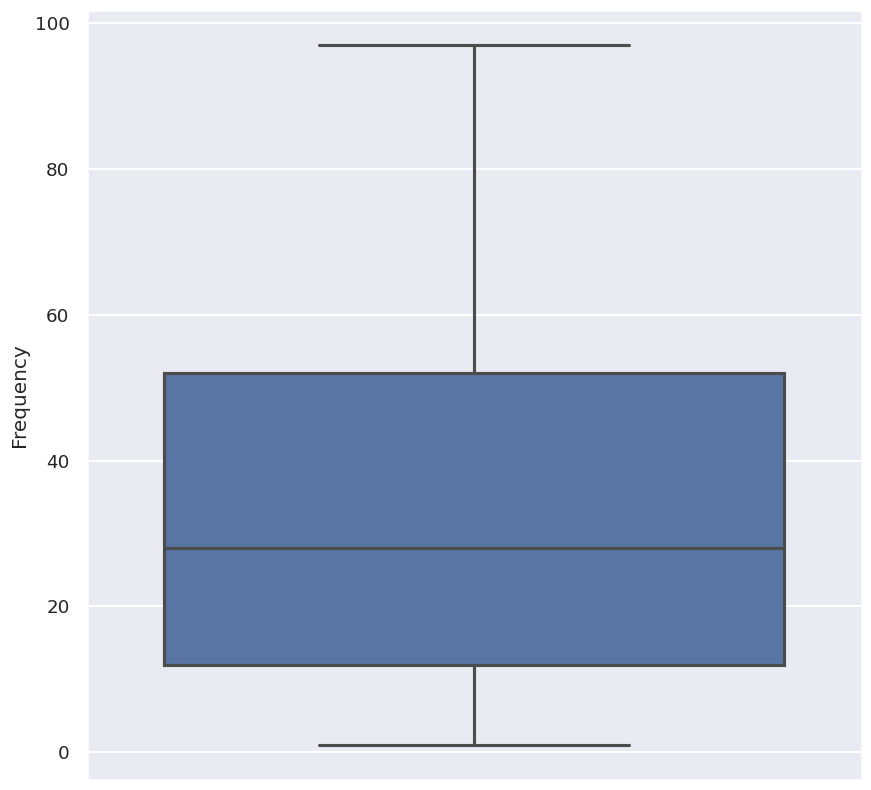

In [169]:
sns.boxplot(df_cl, y='Frequency')

<AxesSubplot: ylabel='Recency'>

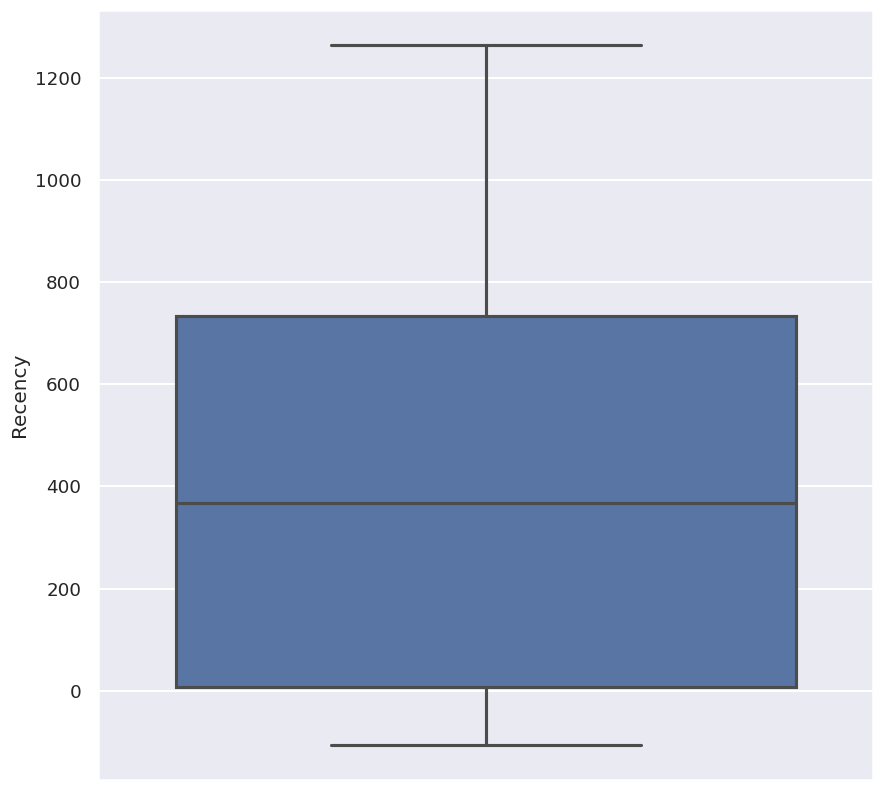

In [170]:
sns.boxplot(df_cl, y='Recency')

# Feature Scaling

In [171]:
from sklearn.preprocessing import StandardScaler
df_cl_scaled = df_cl[['Sales', 'Frequency', 'Recency']]
scaler = StandardScaler()
df_cl_scaled = scaler.fit_transform(df_cl_scaled)
df_cl_scaled.shape

(1585, 3)

In [172]:
df_cl_scaled = pd.DataFrame(df_cl_scaled)
df_cl_scaled.columns = ['Amount', 'Frequency', 'Recency']
df_cl_scaled.head()

,Amount,Frequency,Recency
0,0.864430,0.450344,-0.215871
1,-0.292370,0.450344,-1.104699
2,1.445267,0.267296,0.733216
3,1.099296,1.868967,-0.185742
4,-0.828008,-1.105564,-0.215871


# Clustering

In [173]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, max_iter=50, n_init=10, random_state=0)
kmeans.fit(df_cl_scaled)


KMeans(max_iter=50, n_clusters=4, n_init=10, random_state=0)

In [174]:
from collections import Counter

# Assign the labels to each data point, and execute the following script.
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 544), (1, 280), (2, 461), (3, 300)]

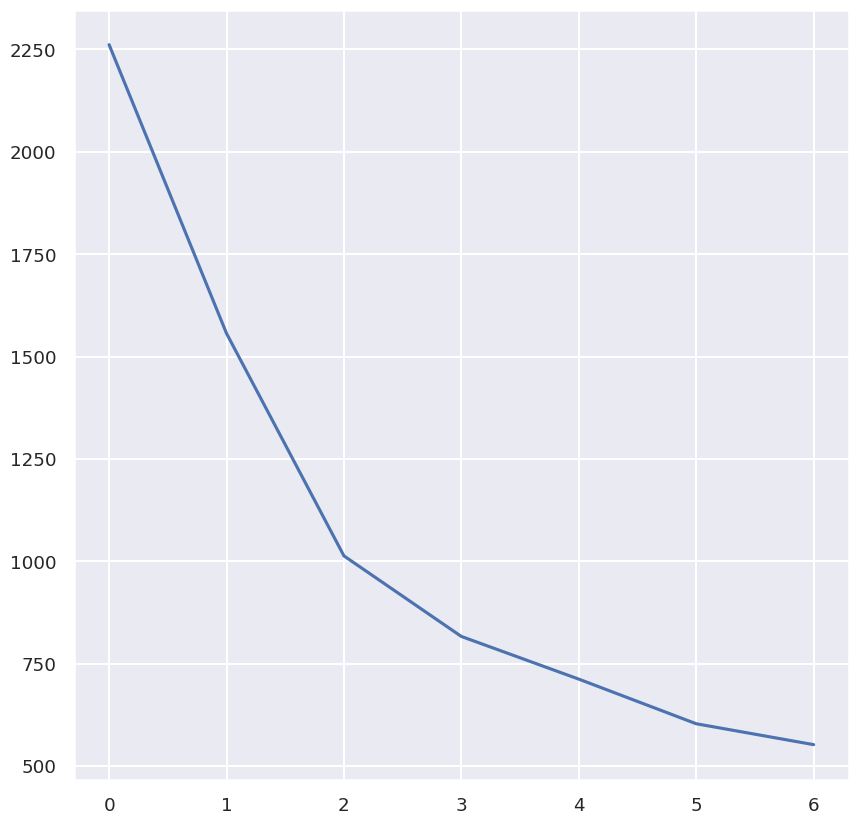

In [175]:
import matplotlib.pyplot as plt
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10, random_state=0)
    kmeans.fit(df_cl_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In [176]:
# Silhouette analysis
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10, random_state=0)
    kmeans.fit(df_cl_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df_cl_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4751988409079479
For n_clusters=3, the silhouette score is 0.4566213476912662
For n_clusters=4, the silhouette score is 0.47855225249010747
For n_clusters=5, the silhouette score is 0.45908430641150916
For n_clusters=6, the silhouette score is 0.4228338997763815
For n_clusters=7, the silhouette score is 0.4176445860170124
For n_clusters=8, the silhouette score is 0.39521309048702546


# Train the model with the optimal number of clusters

In [177]:
kmeans = KMeans(n_clusters=3, max_iter=50, n_init=10, random_state=0)
kmeans.fit(df_cl_scaled)


KMeans(max_iter=50, n_clusters=3, n_init=10, random_state=0)

In [178]:
df_cl['Cluster'] = kmeans.labels_
df_cl.head()

,Customer ID,Sales,Frequency,Recency,Cluster
0,AA-10315,13747.41300,42,355,1
1,AA-10375,5884.19500,42,1,2
2,AA-10480,17695.58978,38,733,1
3,AA-10645,15343.89070,73,367,1
4,AA-315,2243.25600,8,355,2


In [179]:
df_cl.groupby('Cluster').agg({'Sales': 'mean', 'Frequency': 'mean', 'Recency': 'mean'}).round(0)

,Sales,Frequency,Recency
Cluster,,,
0,3262.0,17.0,926.0
1,14665.0,55.0,412.0
2,2522.0,14.0,174.0


# plot amount

<AxesSubplot: xlabel='Frequency', ylabel='Sales'>

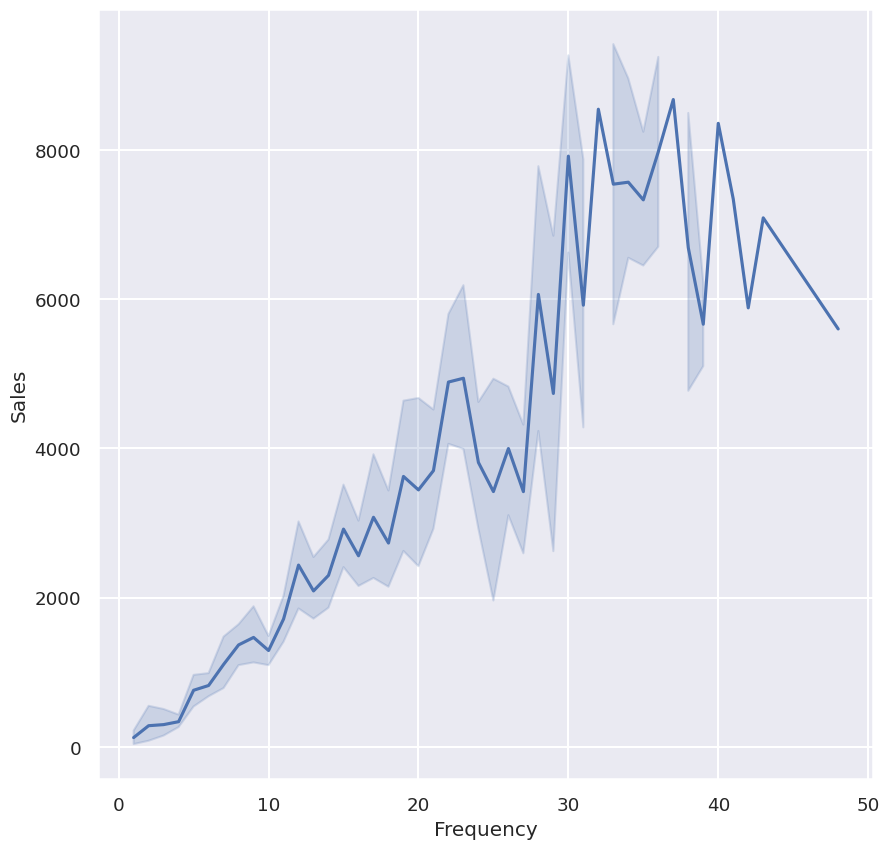

In [180]:
sns.lineplot(x='Frequency', y='Sales', data=df_cl[df_cl['Cluster'] == 2])

<AxesSubplot: xlabel='Cluster', ylabel='Sales'>

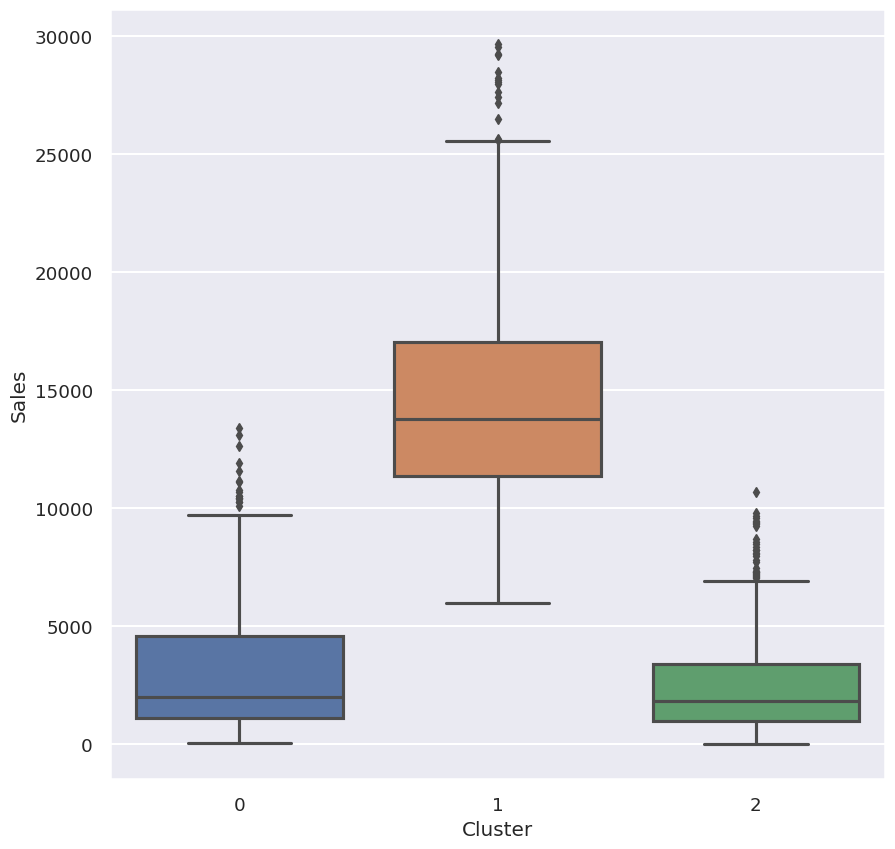

In [181]:
sns.boxplot(x='Cluster', y='Sales', data=df_cl)

<AxesSubplot: xlabel='Cluster', ylabel='Frequency'>

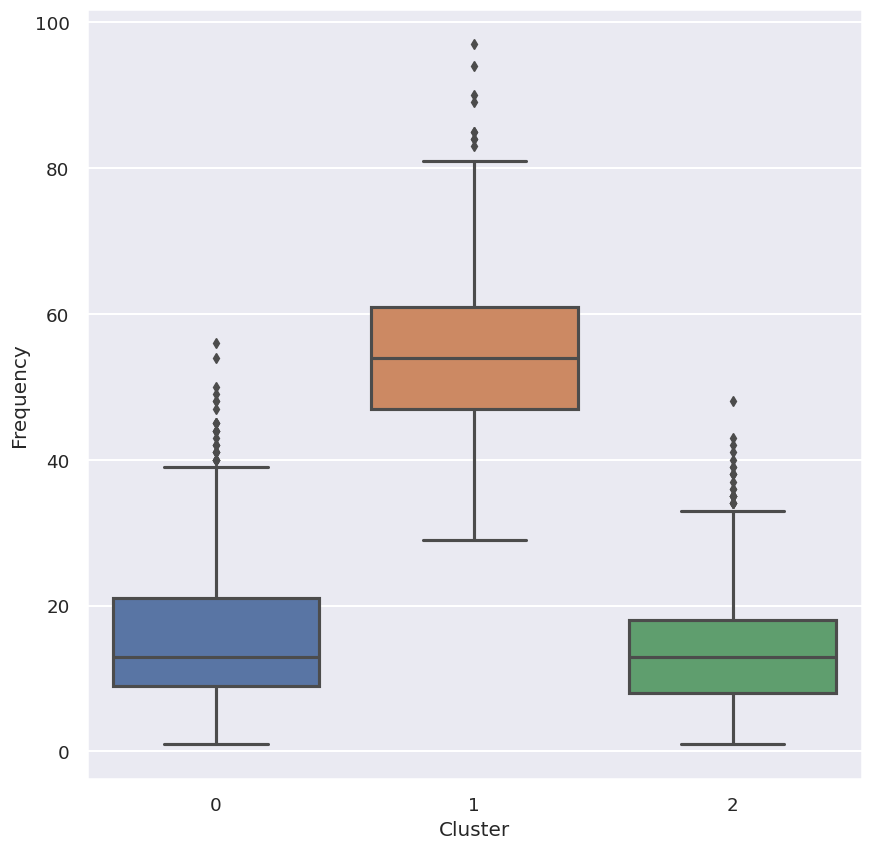

In [182]:
sns.boxplot(x='Cluster', y='Frequency', data=df_cl)

<AxesSubplot: xlabel='Cluster', ylabel='Recency'>

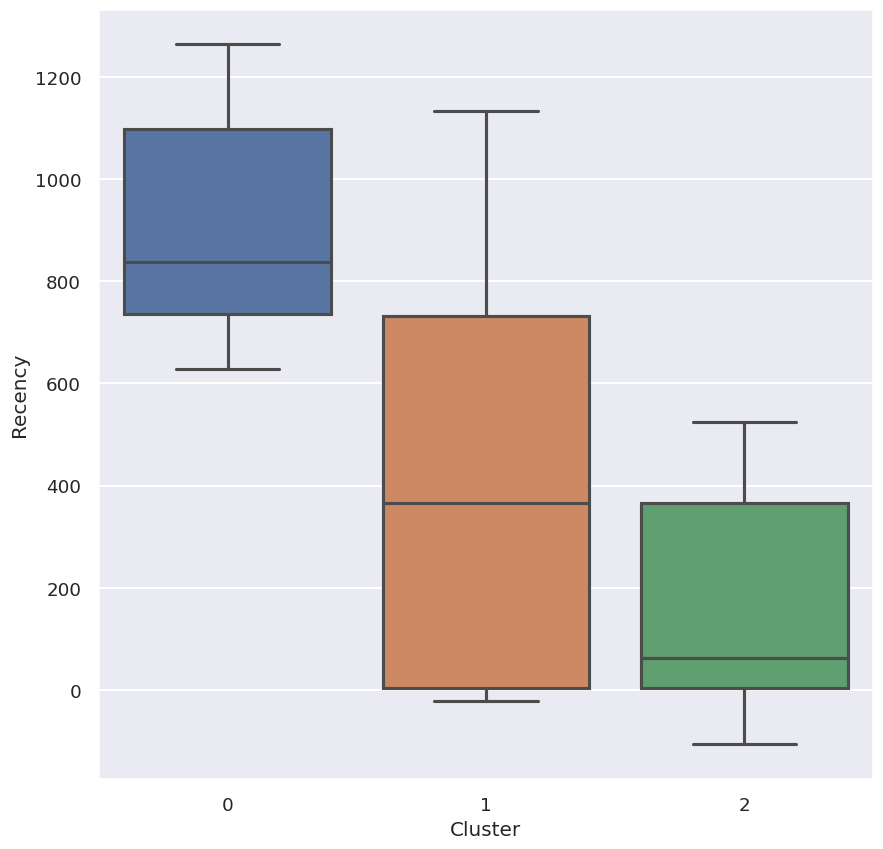

In [183]:
sns.boxplot(x='Cluster', y='Recency', data=df_cl)

In [184]:
# Universal class to cluster the data
class ClusterStuff:
    def __init__(self, df, group_by, columns, method='mean'):
        self.df = df
        self.group_by = group_by
        self.columns = columns
        self.method = method

        self.df_grouped = None
        self.df_scaled = None

        # perform the operations
        self.get_data()
        self.remove_outliers()
        self.scale_data()

    def get_data(self):
        self.df_grouped = self.df.groupby(self.group_by)[self.columns].agg(self.method)
        self.df_grouped = self.df_grouped.reset_index()
        self.df_grouped.columns = [self.group_by] + self.columns

    def scale_data(self):
        scaler = StandardScaler()
        self.df_scaled = scaler.fit_transform(self.df_grouped[self.columns])
        self.df_scaled = pd.DataFrame(self.df_scaled, columns=self.columns)

    def plot_elbow(self):
        ssd = []
        range_n_clusters = range(2, min(len(self.df_grouped), 10))
        for num_clusters in range_n_clusters:
            kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10, random_state=0)
            kmeans.fit(self.df_scaled)

            ssd.append(kmeans.inertia_)

        # plot the SSDs for each n_clusters
        plt.plot(ssd)
        plt.show()

    def silhouette(self):
        range_n_clusters = range(2, min(len(self.df_grouped), 10))
        for num_clusters in range_n_clusters:
            # intialise kmeans
            kmeans = KMeans(n_clusters=num_clusters, max_iter=50, n_init=10, random_state=0)
            kmeans.fit(self.df_scaled)

            cluster_labels = kmeans.labels_

            # silhouette score
            silhouette_avg = silhouette_score(self.df_scaled, cluster_labels)
            print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

    def remove_outliers_for_column(self, df, column):
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_data = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        return filtered_data

    def remove_outliers(self):
        for col in self.columns:
            self.df_grouped = self.remove_outliers_for_column(self.df_grouped, col)

    def cluster(self, k):
        kmeans = KMeans(n_clusters=k, max_iter=50, n_init=10, random_state=0)
        kmeans.fit(self.df_scaled)

        self.df_grouped['Cluster'] = kmeans.labels_
        # add cluster column to original self.df
        self.df = pd.merge(self.df, self.df_grouped[[self.group_by, 'Cluster']], on=self.group_by)

    def boxplot_all_columns(self):
        # increase size of the plot
        plt.rcParams['figure.figsize'] = [10, 10]
        sns.set_context("talk", font_scale=0.8)
        for col in self.columns:
            sns.boxplot(x='Cluster', y=col, data=self.df_grouped)
            plt.show()




# Clustering

In [185]:
# add recency field to the dataframe
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Recency'] = (df['Order Date'].max() - df['Order Date']).dt.days

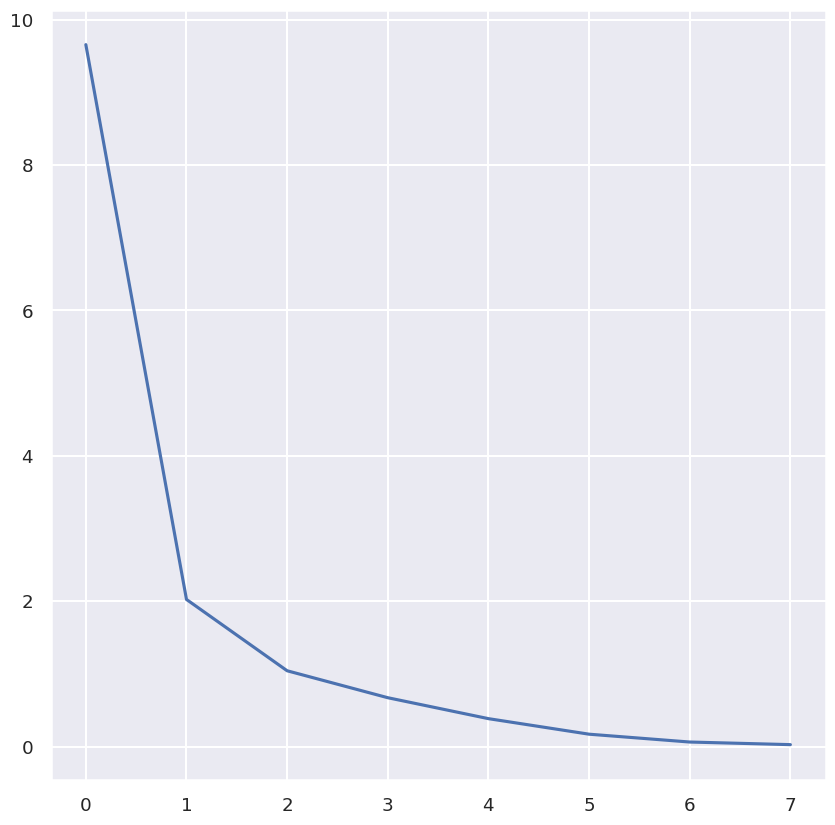

In [209]:
cl = ClusterStuff(df, 'Sub-Category', ['Sales', 'Quantity', 'Profit'], 'sum')
cl.plot_elbow()

In [210]:
cl.silhouette()

For n_clusters=2, the silhouette score is 0.6761732119742698
For n_clusters=3, the silhouette score is 0.7519854662871922
For n_clusters=4, the silhouette score is 0.7085589073700886
For n_clusters=5, the silhouette score is 0.5906185162548829
For n_clusters=6, the silhouette score is 0.5090630962953298
For n_clusters=7, the silhouette score is 0.5327721275079538
For n_clusters=8, the silhouette score is 0.4486365312000562
For n_clusters=9, the silhouette score is 0.3499979071628553


In [211]:
cl.cluster(2)
cl.df_grouped

,Sub-Category,Sales,Quantity,Profit,Cluster
0,Accessories,3075,3075,3075,1
1,Appliances,1755,1755,1755,0
4,Bookcases,2411,2411,2411,0
5,Chairs,3434,3434,3434,1
6,Copiers,2223,2223,2223,0
7,Envelopes,2435,2435,2435,0
8,Fasteners,2420,2420,2420,0
9,Furnishings,3170,3170,3170,1
10,Labels,2606,2606,2606,0
11,Machines,1486,1486,1486,0


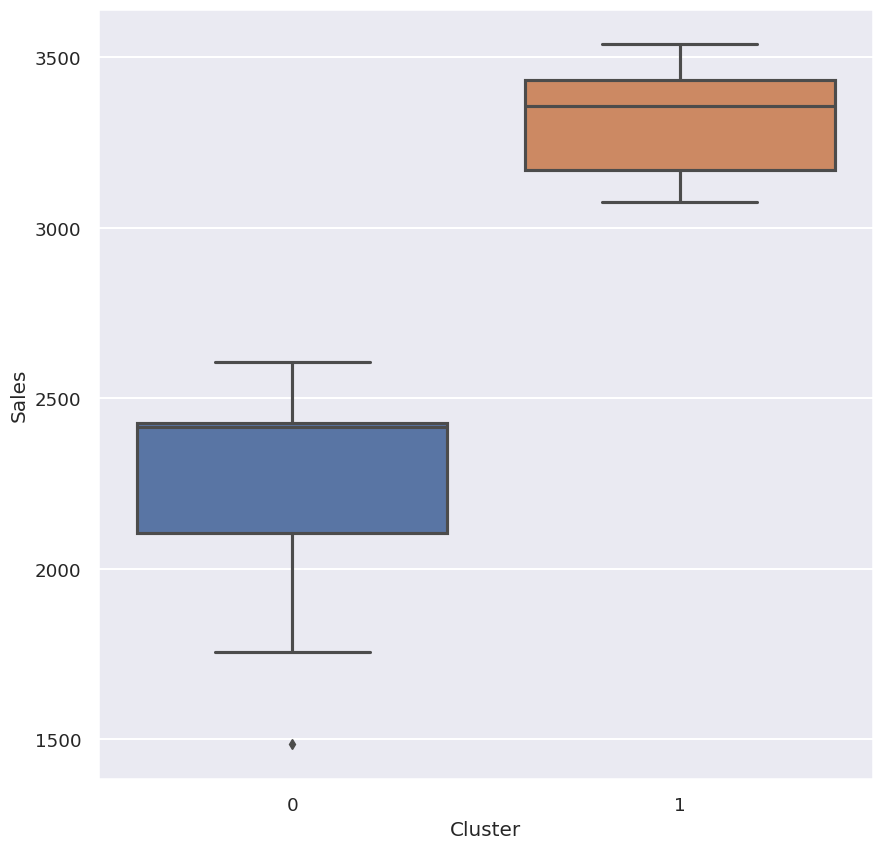

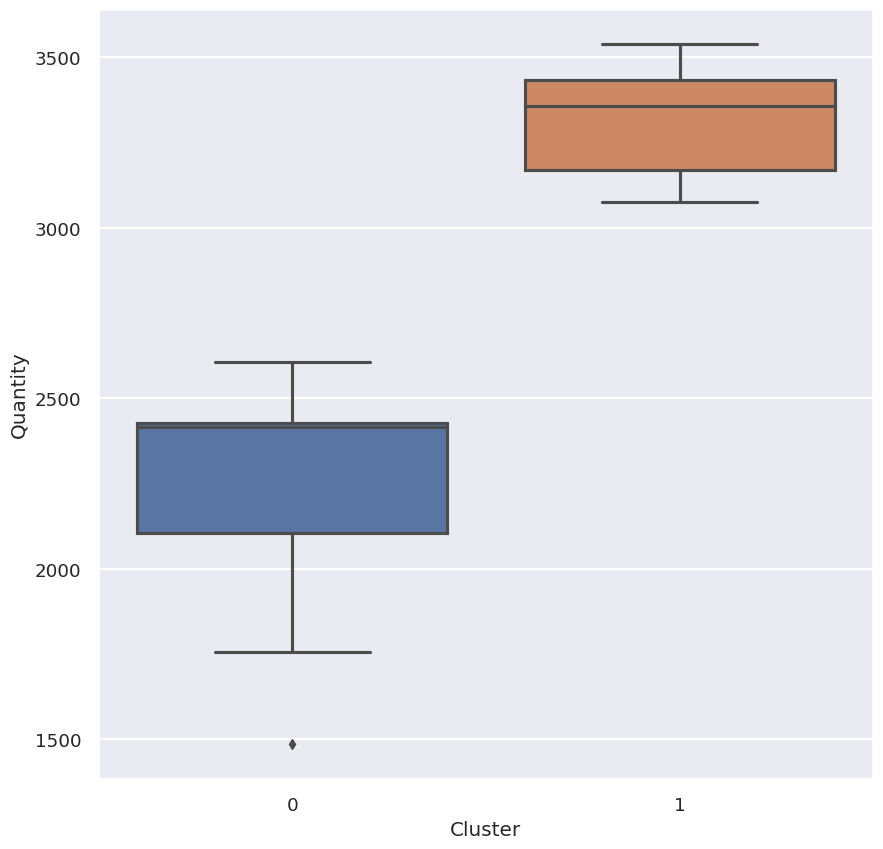

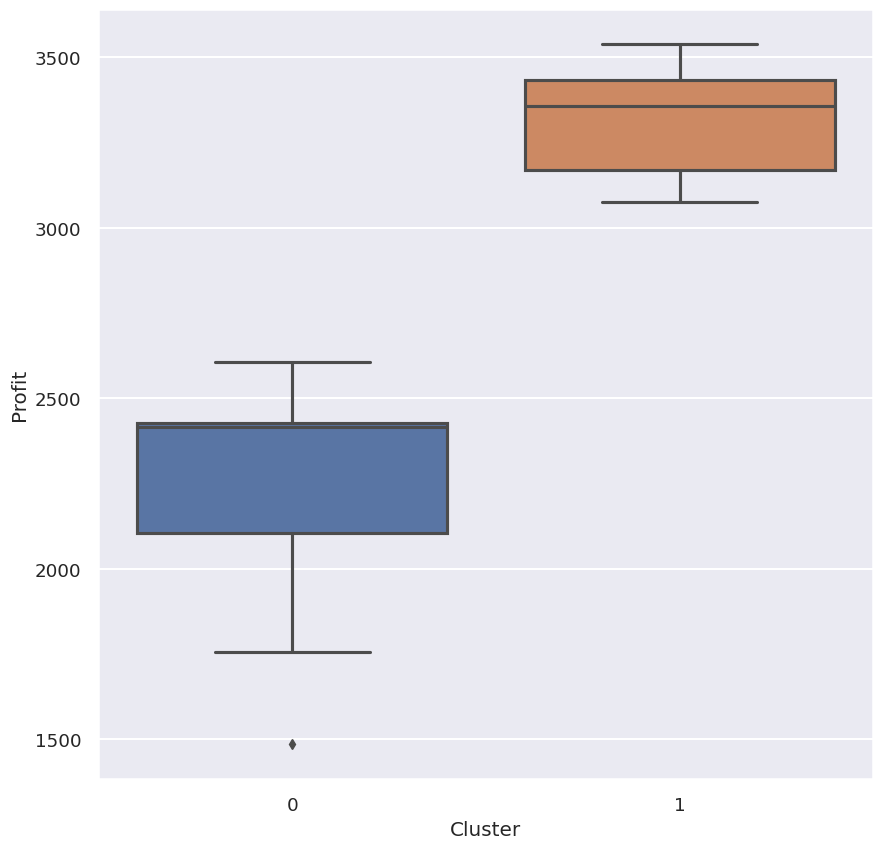

In [212]:
cl.boxplot_all_columns()

In [191]:
# show top mean sales by country in each cluster
cl.df_grouped.groupby('Cluster').apply(lambda x: x.sort_values('Profit', ascending=False).head(10))

Product ID     Profit  Quantity  Discount  Cluster
Cluster                                                                
0       1893   FUR-SAU-10004137  79.080000  2.000000  0.333333        0
        9401    TEC-MA-10003626  69.810500  3.000000  0.400000        0
        1910    FUR-TA-10000245  67.302667  2.333333  0.366667        0
        2116    FUR-TA-10003576  63.606000  2.000000  0.300000        0
        1986    FUR-TA-10001558  63.144000  2.000000  0.400000        0
        2005    FUR-TA-10001833  62.352000  2.000000  0.400000        0
        6812    OFF-ST-10000210  56.868000  2.000000  0.300000        0
        9324    TEC-MA-10002790  55.998600  2.000000  0.400000        0
        1964    FUR-TA-10001226  55.140000  2.000000  0.400000        0
        6874    OFF-ST-10000752  51.952886  2.571429  0.281429        0
1       2578    OFF-AP-10002425  95.454667  2.333333  0.066667        1
        9478    TEC-MA-10004603  95.338500  2.000000  0.162500        1
        4210   OFF-ELD-10002199  94.577143  1.714286  0.000000        1
        8768    TEC-CO-10002240  93.720000  2.000000  0.000000        1
        9613   TEC-PAN-10002613  93.300000  1.666667  0.000000        1
        9090   TEC-KON-10002194  93.161250  1.750000  0.175000        1
        1878   FUR-SAU-10002043  93.120000  2.000000  0.000000        1
        1746   FUR-LES-10000904  91.380000  2.000000  0.000000        1
        984     FUR-CH-10004705  91.380000  2.000000  0.000000        1
        9223    TEC-MA-10001372  91.111500  1.500000  0.050000        1
2       9336    TEC-MA-10002931  96.222000  4.666667  0.033333        2
        8659    TEC-CO-10001093  96.164280  3.000000  0.002000        2
        7669    OFF-SU-10003072  96.160000  5.333333  0.000000        2
        714     FUR-CH-10002060  96.090000  5.000000  0.050000        2
        8858    TEC-CO-10003318  95.643640  4.750000  0.102000        2
        1836   FUR-SAF-10000678  95.640000  4.000000  0.000000        2
        8816    TEC-CO-10002700  95.049960  3.000000  0.102000        2
        2737    OFF-AP-10004293  95.004000  6.000000  0.400000        2
        2456    OFF-AP-10001169  94.940000  4.333333  0.066667        2
        10123   TEC-PH-10004389  94.912467  3.666667  0.066667        2

In [192]:
cl.df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Recency,Cluster
0,31192,IN-2012-86369,2012-04-14,4/18/2012,Standard Class,MB-18085,Mick Brown,Consumer,Hamilton,Waikato,...,Tables,"Chromcraft Conference Table, Fully Assembled",5244.840,6,0.0,996.4800,878.38,High,991,2
1,36923,CA-2011-126683,2011-09-29,10/1/2011,Second Class,PP-18955,Paul Prost,Home Office,Seattle,Washington,...,Tables,"Bevis Oval Conference Table, Walnut",2348.820,9,0.0,399.2994,259.81,High,1189,2
2,39477,CA-2012-119879,2012-11-21,11/25/2012,Standard Class,SS-20410,Shahid Shariari,Consumer,Philadelphia,Pennsylvania,...,Tables,"Bevis Oval Conference Table, Walnut",1252.704,8,0.4,-480.2032,109.30,Medium,770,2
3,39659,CA-2014-147207,2014-01-03,1/5/2014,Second Class,TS-21655,Trudy Schmidt,Consumer,El Paso,Texas,...,Tables,"Bevis Oval Conference Table, Walnut",913.430,5,0.3,-169.6370,108.98,High,362,2
4,36013,CA-2014-143126,2014-12-04,12/8/2014,Second Class,CM-12655,Corinna Mitchell,Home Office,Seattle,Washington,...,Tables,"Bevis Oval Conference Table, Walnut",521.960,2,0.0,88.7332,84.78,Medium,27,2


In [193]:
cl.df['Order Date'] = pd.to_datetime(cl.df['Order Date'])
cl.df['order_year_month'] = cl.df['Order Date'].dt.strftime('%Y-%m')

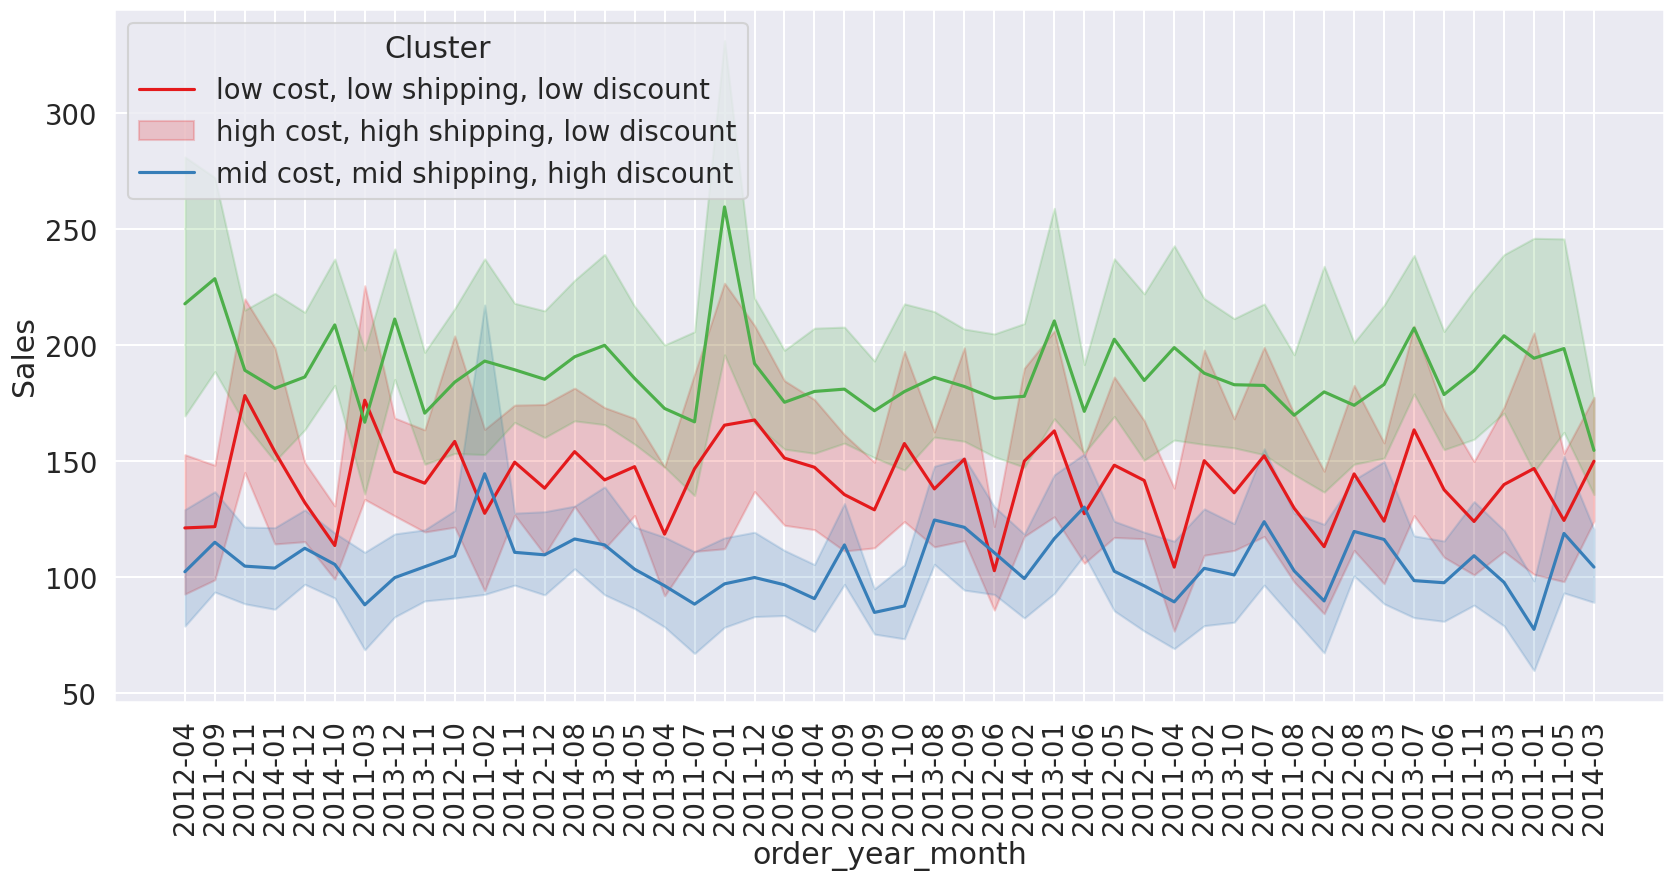

In [195]:
# plot profits over time for each cluster
sns.set(rc={'figure.figsize':(20,9)})
sns.set_context('talk', font_scale=1.2)
sns.lineplot(x='order_year_month', y='Sales', hue='Cluster', data=cl.df, palette='Set1')
plt.xticks(rotation=90)
# rename legend
labels = [
    'low cost, low shipping, low discount',
    'high cost, high shipping, low discount',
    'mid cost, mid shipping, high discount'
]
plt.legend(title='Cluster', loc='upper left', labels=labels)

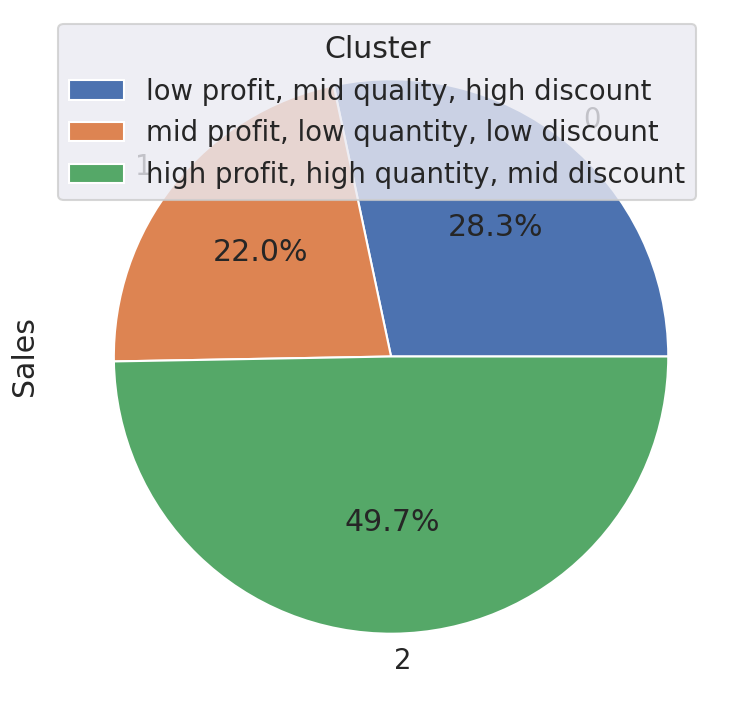

In [197]:
# plot pie chart with sum sales for each cluster
cl.df.groupby('Cluster').agg({'Sales': 'sum'}).plot(kind='pie', subplots=True, figsize=(20, 9), autopct='%1.1f%%')
# rename legend
labels = [
    'low profit, mid quality, high discount',
    'mid profit, low quantity, low discount',
    'high profit, high quantity, mid discount'
]
plt.legend(title='Cluster', loc='upper left', labels=labels)

array([<AxesSubplot: ylabel='Sales'>], dtype=object)

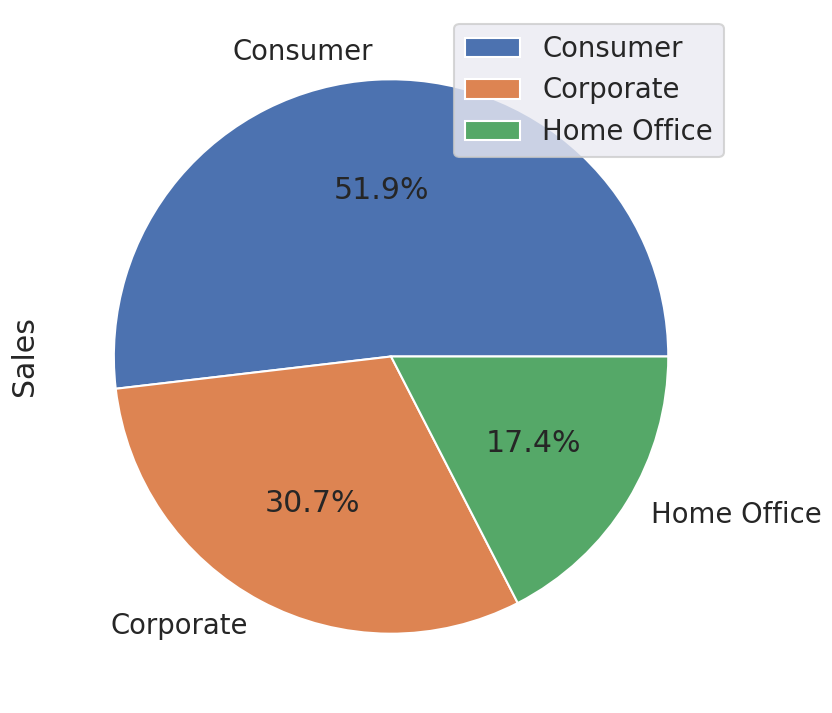

In [198]:
# plot pie chart of sales for different Segment in cluster 2
cl.df[cl.df['Cluster'] == 2].groupby('Segment').agg({'Sales': 'sum'}).plot(kind='pie', subplots=True, figsize=(20, 9), autopct='%1.1f%%')

array([<AxesSubplot: ylabel='Sales'>], dtype=object)

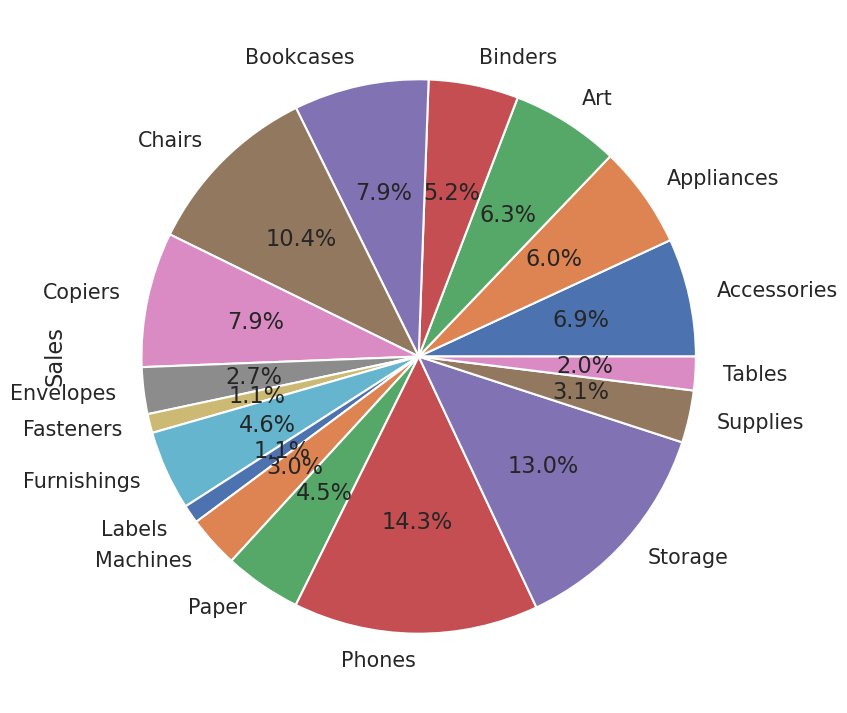

In [205]:
sns.set_context('talk', font_scale=0.9)
cl.df[cl.df['Cluster'] == 2].groupby('Sub-Category').agg({'Sales': 'sum'}).plot(kind='pie', subplots=True, figsize=(20, 9), autopct='%1.1f%%', legend=None)
